In [2]:
import sys

sys.path.append("../")


In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

DATA_PATH = '../../data/1m'

In [10]:
import traceback

selected_pairs = ['MATIC-USDT', 'ETH-USDT', 'ALGO-USDT']

data = []
start_date = '2020-01-01'
test_end = '2020-12-01'
end_date = '2021-03-01'

for symbol in selected_pairs:
    try:
        df = pd.read_csv(f'{DATA_PATH}/{symbol}.csv', 
                        parse_dates=['OpenTime'], 
                        index_col=['OpenTime'])

        df.rename(columns={'Close': symbol}, inplace=True)
        df = df[~df.index.duplicated(keep='first')]
        # the data is too long, just limit to recent period
        data.append(df[symbol])
    except:
        traceback.print_exc()

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
df.dropna(inplace=True, how='any')

df.head()

,MATIC-USDT,ETH-USDT,ALGO-USDT
OpenTime,,,
2022-02-18 22:52:00,1.5882,2776.29,0.8906
2022-02-18 22:53:00,1.5895,2777.96,0.8908
2022-02-18 22:54:00,1.5900,2778.71,0.8907
2022-02-18 22:55:00,1.5889,2774.63,0.8898
2022-02-18 22:56:00,1.5896,2776.00,0.8901


In [11]:
df.tail()


,MATIC-USDT,ETH-USDT,ALGO-USDT
OpenTime,,,
2022-02-19 15:27:00,1.5987,2740.13,0.8891
2022-02-19 15:28:00,1.5982,2740.87,0.8894
2022-02-19 15:29:00,1.5995,2740.93,0.8896
2022-02-19 15:30:00,1.5963,2737.60,0.8880
2022-02-19 15:31:00,1.5979,2738.04,0.8885


In [12]:
def adf_test(timeseries, verbose=False):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    if verbose:
        print ('Results of Dickey-Fuller Test:')
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput)
    return dfoutput['p-value']

In [13]:
def pp_test(timeseries, verbose=False):
    pp = PhillipsPerron(timeseries)
    if verbose:
        print(pp.summary().as_text())
    
    return pp.pvalue


def kpss_test(timeseries, verbose=False):
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])

    if verbose:
        print ('Results of KPSS Test:')
        for key,value in kpsstest[3].items():
            kpss_output['Critical Value (%s)'%key] = value
        print (kpss_output)
    return kpss_output['p-value']


In [14]:
methods = {
    'adf': adf_test,
    'pp': pp_test,
    'kpss': kpss_test
}


def perform_test(method, series):
    func_ = methods[method]
    
    # p_v1 = func_(np.log(series))
    p_v1 = func_(series)

    # diff = np.log(series) - np.log(series.shift(1))
    diff = series.diff()
    diff.dropna(inplace=True)
    p_v2 = func_(diff)

    return p_v1, p_v2

In [15]:
data = {
    'adf': [],
    'pp': [],
    'kpss': []
}
columns = []

for col in df.columns:
    for test in methods.keys():
        p1, p2 = perform_test(test, df[col])
        data[test].append(p1)
        data[test].append(p2)
    
    if col not in columns:
        columns.append(col)
    
    if f'd_{col}' not in columns:
        columns.append(f'd_{col}')

    

test_df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
test_df.head()

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning
/home/bean/miniconda3/envs/t

,MATIC-USDT,d_MATIC-USDT,ETH-USDT,d_ETH-USDT,ALGO-USDT,d_ALGO-USDT
adf,0.473695,0.0,0.835089,0.0,0.667481,0.0
pp,0.499920,0.0,0.835241,0.0,0.706426,0.0
kpss,0.010000,0.1,0.010000,0.1,0.010000,0.1


The prices are not stationary but they all become stationary after the first differencing.
For both adf and pp for the first differencing, `p-value` < 0.05 so we can reject the null.
KPSS all 3 diff series is above the critical value so we can accept the null (series is stationary).

Therefore, we can conclude that ETH, BCH, XLM are `I(1)` processes.

which:
- I(0): trend stationary
- I(1): diference stationary


The Engle-Granger method involves a linear regression on given time series data which,
in this case, is BTC; but it is not important which cryptocurrency is taken as the dependent
variable. We propose the following OLS model:

$$
ETH_t = c + \beta_1 BCH_t + \beta_2 XLM_t + \epsilon_t
$$

In [16]:
renamed = {col: col.replace('-USDT', '') for col in df.columns}

df.rename(columns=renamed, inplace=True)

In [17]:
df = sm.add_constant(df)
df

/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,MATIC,ETH,ALGO
OpenTime,,,,
2022-02-18 22:52:00,1.0,1.5882,2776.29,0.8906
2022-02-18 22:53:00,1.0,1.5895,2777.96,0.8908
2022-02-18 22:54:00,1.0,1.5900,2778.71,0.8907
2022-02-18 22:55:00,1.0,1.5889,2774.63,0.8898
2022-02-18 22:56:00,1.0,1.5896,2776.00,0.8901
...,...,...,...,...
2022-02-19 15:27:00,1.0,1.5987,2740.13,0.8891
2022-02-19 15:28:00,1.0,1.5982,2740.87,0.8894
2022-02-19 15:29:00,1.0,1.5995,2740.93,0.8896


In [18]:

model = sm.OLS.from_formula(formula='ETH ~ const + MATIC + ALGO', data=df)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     2958.
Date:                Sat, 19 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:37:09   Log-Likelihood:                -3849.1
No. Observations:                1000   AIC:                             7706.
Df Residuals:                     996   BIC:                             7726.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.186e+14   5.48e+13     -2.164      0.0

From above Table, we obtain the relationships:

$$
ETH = 0.38 + 1.141BCH + 0.08XLM + \epsilon_t
$$

Notably, all the regressing coefficients appear to be statistically significant with p-values less than 1%.
R-squared: 0.935%.

In [19]:
results.resid.head()

OpenTime
2022-02-18 22:52:00    23.727500
2022-02-18 22:53:00    23.741250
2022-02-18 22:54:00    24.053750
2022-02-18 22:55:00    22.239375
2022-02-18 22:56:00    22.484375
dtype: float64

In [20]:
results.params

Intercept   -1.185598e+14
const        1.185598e+14
MATIC        1.098746e+03
ALGO         1.175094e+03
dtype: float64

<AxesSubplot:xlabel='OpenTime'>

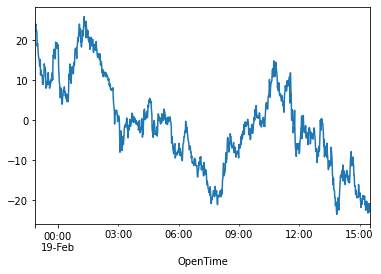

In [21]:
results.resid.plot()

In [22]:
adf_test(results.resid, verbose=True)

Results of Dickey-Fuller Test:
Test Statistic                  -1.907332
p-value                          0.328620
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


0.32861976296079687

In [23]:
pp_test(results.resid, verbose=True)

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.003
P-value                         0.285
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


0.2850835389864701

In [24]:
kpss_test(results.resid, verbose=True)

Results of KPSS Test:
Test Statistic            2.496442
p-value                   0.010000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/bean/miniconda3/envs/trade/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


0.01

In [108]:
s1 = df['BTC']
s2 = df['ETH']
s3 = df['BCH']
s4 = df['LTC']

hedge_ratio = (results.params['ETH'], results.params['BCH'], results.params['LTC'])
print(hedge_ratio)

spread = s1 - hedge_ratio[0] * s2 - hedge_ratio[1] * s3 - hedge_ratio[2] * s4
spread 

(16.101308509559374, -13.483659162183518, 123.1079417209483)


open_time
2019-11-28 10:00:00    2183.452841
2019-11-28 11:00:00    2162.133252
2019-11-28 12:00:00    2182.928077
2019-11-28 13:00:00    2192.404801
2019-11-28 14:00:00    2188.688809
                          ...     
2020-11-30 19:00:00    3209.548598
2020-11-30 20:00:00    3247.136772
2020-11-30 21:00:00    3202.361860
2020-11-30 22:00:00    3188.278039
2020-11-30 23:00:00    3257.352950
Length: 8833, dtype: float64

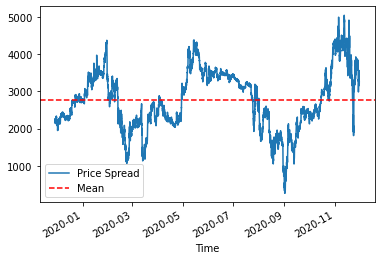

In [109]:
spread.plot() # Plot the spread
plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
plt.xlabel('Time')
plt.legend(['Price Spread', 'Mean'])

In [110]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

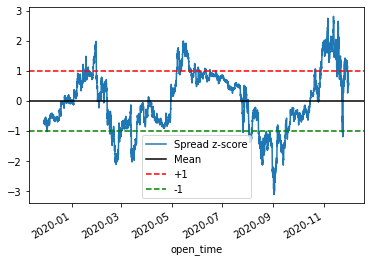

In [111]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1'])